<a href="https://colab.research.google.com/github/skanderbenmansour/nlp_study_group/blob/master/skander/LSTM_char_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import string
from collections import defaultdict, Counter
import numpy as np
from tqdm import tqdm_notebook as tqdm

import pandas as pd
import json
import re

torch.manual_seed(1)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Health_and_Personal_Care_5.json'

In [0]:
# path = 'C:/Users/skand/Downloads/reviews_Health_and_Personal_Care_5.json/Health_and_Personal_Care_5.json'

In [0]:
data = []

with open(path,'r',encoding='utf8') as file:
  for line in tqdm(file):
    data.append(json.loads(line.strip()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
df = pd.DataFrame(data)
print(df.shape)
df.head()

(346355, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011"


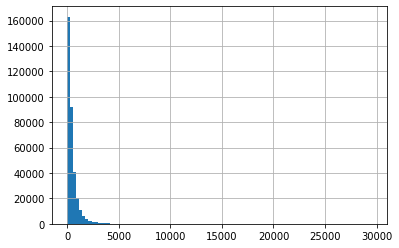

In [0]:
df['n_chars'] = df['reviewText'].apply(len)
df['n_chars'].hist(bins = 100)

In [0]:
print(df.shape)
df = df[df['n_chars'] < 2000]
df.shape

(346355, 10)


(337115, 10)

In [0]:
print(df.shape)
df = df[df['n_chars'] > 200]
df.shape

(337115, 10)


(230498, 10)

In [0]:
regex_sentences = re.compile(r'[^\.!?]*[\.!?]*', re.M)
get_sentences = lambda text: [sentence.strip() for sentence in regex_sentences.findall(text.lower()) if sentence.strip()]
text = 'Hello how, aren\'t you! !? Friend! Bla'
get_sentences(text)

["hello how, aren't you!", '!?', 'friend!', 'bla']

In [0]:
regex_text = re.compile(r"[\w']+")
get_text = lambda text: [word for word in regex_text.findall(text.lower()) if word]

regex_ending = re.compile('[\.!?]+')
get_ending = lambda text: regex_ending.findall(text)

get_words = lambda text: get_text(text) + get_ending(text)

get_all = lambda text: [word 
                        for words in [get_text(text) + get_ending(text) for text in get_sentences(text)] 
                        for word in words
                        if word] + ['STOP']

print(text)
print(get_all(text))


Hello how, aren't you! !? Friend! Bla
['hello', 'how', "aren't", 'you', '!', '!?', 'friend', '!', 'bla', 'STOP']


In [0]:
df['sentences'] = df['reviewText'].apply(get_all)
df['sentences'].head()

0    [this, is, a, great, little, gadget, to, have,...
1    [i, would, recommend, this, for, a, travel, ma...
2    [what, i, liked, was, the, quality, of, the, l...
3    [love, the, great, point, light, pocket, magni...
4    [this, is, very, nice, ., you, pull, out, on, ...
Name: sentences, dtype: object

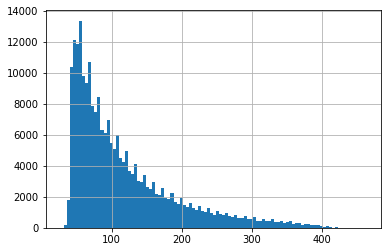

In [0]:
df['sentences'].apply(len).hist(bins=100)

In [0]:
vocab = Counter([word for words in df['sentences'] for word in words])

In [0]:
vocab = pd.DataFrame(vocab.items(),columns=['word','count'])
vocab.head()

,word,count
0,this,370761
1,is,373361
2,a,659864
3,great,65617
4,little,41371


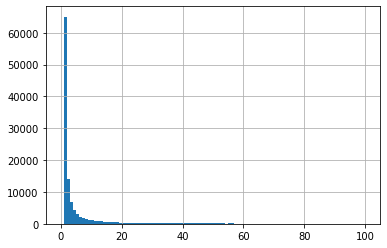

In [0]:
vocab['count'].hist(bins=100,range=(0,100))

In [0]:
threshold = 200
len(vocab),sum(vocab['count']>threshold)

(124107, 5678)

In [0]:
vocab = vocab[vocab['count']>threshold]
word_id = dict(zip(vocab.sort_values('count',ascending=False)['word'],range(len(vocab))))

In [0]:
inverse_word_id = {v:k for k,v in word_id.items()}

In [0]:
VOCAB_SIZE = len(word_id)

In [0]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [0]:
prepare_sequence('the dog ate the apple'.split(),word_id)

tensor([   1, 1129, 2163,    1, 1814])

In [0]:
WORD_EMBEDDING_SIZE = 10
HIDDEN_DIM_LSTM = 10

In [0]:
def init_hidden(dim):
        return (torch.zeros(1, 1, dim),
                torch.zeros(1, 1, dim))

In [0]:
class WordLevelSTM(nn.Module):

    def __init__(self):
        super(WordLevelSTM, self).__init__()
        
        self.nn_word_embeddings = nn.Embedding(VOCAB_SIZE, WORD_EMBEDDING_SIZE)
        self.lstm_full = nn.LSTM(WORD_EMBEDDING_SIZE, HIDDEN_DIM_LSTM)  
        self.hidden_full = init_hidden(HIDDEN_DIM_LSTM)
        self.hidden_pred = nn.Linear(HIDDEN_DIM_LSTM, VOCAB_SIZE)    

    def forward(self, sentence):
        
        self.hidden_full = init_hidden(HIDDEN_DIM_LSTM)

        n_words = len(sentence)
    
        tensor = prepare_sequence(sentence,word_id)
        embedding = self.nn_word_embeddings(tensor)

        out, self.hidden_full = self.lstm_full(embedding.view(n_words, 1, -1), self.hidden_full)

        pred = self.hidden_pred(out[-1])
        scores = F.log_softmax(pred,dim=1)

        return scores

In [0]:
model = WordLevelSTM()
        
        
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
alpha = 0.99

ewma_loss = 0
for epoch in range(10):

    for t,sentence in enumerate(tqdm(df['sentences'])):
        
        sentence = [word for word in sentence if word in word_id]
        n_words = len(sentence)

        for pos in range(1,n_words-1):
            words = sentence[:pos]
            target = sentence[pos]

            scores = model(words)

            target_tensor = prepare_sequence([target],word_id)

            loss = loss_function(scores, target_tensor)
            loss.backward()
            optimizer.step()


            ewma_loss = loss if t == 0 else alpha*ewma_loss + (1-alpha)*loss
            
            if t and t % 10 == 0 and pos < 20:
                
                if pos == 1:
                  print('\n\nEpoch #%2s : %5.2fm sentences --> loss = %5.3f' % (epoch,t/1000000,ewma_loss))
                argmax = int(scores.argmax())
                pred_word = inverse_word_id[argmax]
                print('%15s [%15s] : %s' % (pred_word.upper() if pred_word == target else pred_word,target,' '.join(words)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch # 0 :  0.00m sentences --> loss = 118.717
        install [          admit] : i'll
      magnifier [             it] : i'll admit
         should [              .] : i'll admit it
             it [              i] : i'll admit it .
              . [           like] : i'll admit it . i
           lens [          crazy] : i'll admit it . i like
            god [           when] : i'll admit it . i like crazy
             do [         people] : i'll admit it . i like crazy when
             to [        started] : i'll admit it . i like crazy when people
          think [           that] : i'll admit it . i like crazy when people started
              . [              i] : i'll admit it . i like crazy when people started that
              . [            get] : i'll admit it . i like crazy when people started that i
          deals [              a] : i'll admit it . i like crazy when people started that i get
           this [     magnifying] : i'll admit it . i like crazy when pe

KeyboardInterrupt: ignored

In [0]:

# sentence = 'the dog ate the apple'.split()
# n_words = len(sentence)
# word_ids = prepare_sequence(sentence,word_id)
# print(word_ids)
# word_embeddings = nn_word_embeddings(word_ids)
# print(word_embeddings)


# # initialise hidden state
# hidden_full = init_hidden(HIDDEN_DIM_LSTM)

# for pos in range(len(sentence)-1):
#     word = sentence[word]
#     tensor = nn_word_embeddings(np.)
    
    
#     tag_space = self.hidden2tag(all_outs.view(n_words, -1))
#     tag_scores = F.log_softmax(tag_space, dim=1)


# for word_embedding in word_embeddings:
#     print(word_embedding.dtype)
#     # Step through the sequence one element at a time.
#     # after each step, hidden contains the hidden state.
#     out, hidden_full = lstm_full(word_embedding.view(1, 1, -1), hidden_full)

# print(out)
# # out is our final embedding
# print(hidden_full)